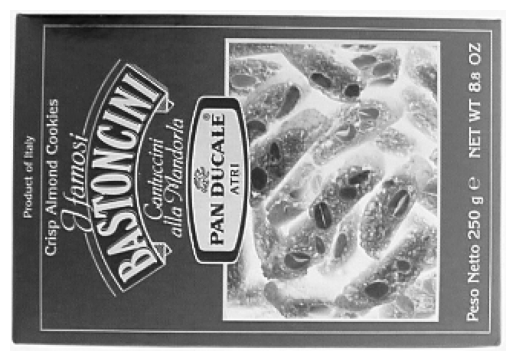

In [1]:
import math
import random
from typing import Union

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow
import numpy as np
import numpy.typing as npt


def get_image(filename: str) -> np.array:
    dir = "images/"
    image = Image.open(dir + filename)
    image_array = np.array(image)
    return image_array


def show_image(array: np.array, mode: Union[str, None] = "Greys"):
    figure()
    plt.axis("off")
    imshow(array, cmap=mode)


show_image(get_image("box.png"))

In [2]:
def scale(img: npt.NDArray[int], multiplier: int):
    h, w = img.shape
    h //= multiplier
    w //= multiplier

    result_image = np.zeros((h, w), dtype=int)

    for i in range(0, h):
        for j in range(0, w):
            result_image[i, j] = int(
                np.mean(img[i * multiplier : (i + 1) * multiplier, j * multiplier : (j + 1) * multiplier])
            )

    return result_image

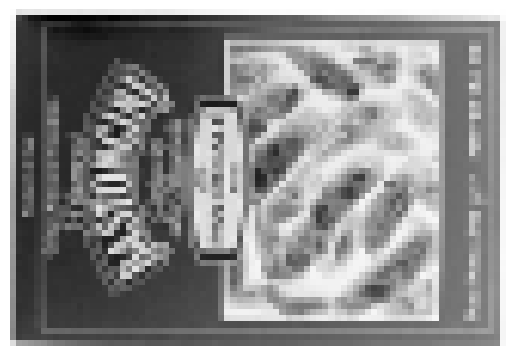

In [3]:
box = get_image("box.png")
test_image = get_image("box_in_scene.png")
box_x2 = scale(box, 2)
box_x4 = scale(box_x2, 2)
show_image(box_x4)

In [4]:
def get_gaussian(size: int, sigma: float = 0.84089642) -> npt.NDArray[float]:
    pad = size // 2

    K = np.zeros((size, size), np.float64)
    for x in range(-pad, -pad + size):
        for y in range(-pad, -pad + size):
            K[x + pad, y + pad] = np.exp(-(x * x + y * y) / (2 * (sigma * sigma)))
    K /= 2 * np.pi * sigma * sigma
    K /= K.sum()
    return K

In [5]:
def fast(image, r, t):

    h, w = image.shape

    result = []
    for i in range(r // 2, h - r // 2):
        for j in range(r // 2, w - r // 2):
            p = image[i, j]
            low_arc = np.concatenate(
                (
                    image[i : i + 2, j - 3],
                    image[i + 2, j - 2],
                    image[i + 3, j - 1 : j + 2],
                    image[i + 2, j + 2],
                    image[i : i + 2, j + 3],
                ),
                axis=None,
            )
            right_arc = np.concatenate(
                (
                    image[i + 3, j : j + 2],
                    image[i + 2, j + 2],
                    image[i - 1 : i + 2, j + 3],
                    image[i - 2, j + 2],
                    image[i - 3, j : j + 2],
                ),
                axis=None,
            )
            full_arc = np.concatenate(
                (
                    image[i - 1 : i + 2, j - 3],
                    image[i + 2, j - 2],
                    image[i + 3, j - 1 : j + 2],
                    image[i + 2, j + 2],
                    image[i - 1 : i + 2, j + 3],
                    image[i - 2, j + 2],
                    image[i - 3, j - 1 : j + 2],
                    image[i - 2, j - 2],
                ),
                axis=None,
            )
            count = 0
            if all(q > p + t for q in low_arc) or all(q > p + t for q in right_arc):
                for q in np.concatenate((full_arc, full_arc), axis=None):
                    # два прохода, чтобы рассмотреть стык в начале окружнсти
                    if q > p + t:
                        count += 1
                    else:
                        count = 0
                    if count >= 12:
                        result.append((i, j))
                        break
            elif all(q < p - t for q in low_arc) or all(q < p - t for q in right_arc):
                for q in np.concatenate((full_arc, full_arc), axis=None):
                    if q < p - t:
                        count += 1
                    else:
                        count = 0
                    if count >= 12:
                        result.append((i, j))
                        break
    return result

In [6]:
fast_box = fast(box, 31, 30)
fast_box_x2 = fast(box_x2, 31, 30)
fast_box_x4 = fast(box_x4, 31, 30)
fast_test = fast(test_image, 31, 30)

In [8]:
W = get_gaussian(5)

In [9]:
def get_gradient(image):
    h, w = image.shape

    img_copy = np.zeros((h + 1, w + 1), dtype=int)

    for i in range(h):
        for j in range(w):
            img_copy[i + 1, j + 1] = image[i, j]

    gradient = np.zeros((h + 1, w + 1, 2), dtype=float)

    for i in range(1, h):
        for j in range(1, w):
            gradient[i, j, 0] = (
                img_copy[i + 1, j]
                - img_copy[i - 1, j]
                + img_copy[i + 1, j - 1]
                - img_copy[i - 1, j - 1]
                + img_copy[i + 1, j + 1]
                - img_copy[i - 1, j + 1]
            ) / 6
            gradient[i, j, 1] = (
                img_copy[i, j + 1]
                - img_copy[i, j - 1]
                + img_copy[i - 1, j + 1]
                - img_copy[i - 1, j - 1]
                + img_copy[i + 1, j + 1]
                - img_copy[i + 1, j - 1]
            ) / 6

    return gradient[1 : h + 1, 1 : w + 1]

In [10]:
grad_box = get_gradient(box)
grad_box_x2 = get_gradient(box_x2)
grad_box_x4 = get_gradient(box_x4)

In [11]:
grad_test = get_gradient(test_image)

In [12]:
def __get_M(image, grad, x, y):
    h, w = image.shape

    image_copy = np.zeros((h + 4, w + 4), dtype=int)
    image_copy[2 : h + 2, 2 : w + 2] = image

    M = np.zeros((2, 2), dtype=float)
    for i in range(x - 2, x + 3):
        for j in range(y - 2, y + 3):
            Ix = grad[i, j, 0]
            Iy = grad[i, j, 1]
            A = np.array([[Ix**2, Ix * Iy], [Ix * Iy, Iy**2]], dtype=float).reshape((2, 2))
            new = np.sum(W * image_copy[i - 2 + 2 : i + 3 + 2, j - 2 + 2 : j + 3 + 2]) * A
            M = np.add(M, new)
    return M

In [13]:
def get_M(image, grad, fast_points):
    return [__get_M(image, grad, x, y) for x, y in fast_points]

In [14]:
M_box = get_M(box, grad_box, fast_box)
M_box_x2 = get_M(box, grad_box_x2, fast_box_x2)
M_box_x4 = get_M(box, grad_box_x4, fast_box_x4)
M_test = get_M(test_image, grad_test, fast_test)

In [17]:
def get_R(M, k):
    return [np.linalg.det(m) - k * np.trace(m) ** 2 for m in M]

In [18]:
k = 0.04
R_box = get_R(M_box, k)
R_box_x2 = get_R(M_box_x2, k)
R_box_x4 = get_R(M_box_x4, k)
R_test = get_R(M_test, k)

[48196133340.98035, 15970961401.910378, 37851468218.585144, 97287090736.77179, 130198767569.14815, -4987709362.166199, 23770159729.80475, 98728854098.33426, -82993299345.76297, 341969441676.14087, 397602271731.7699, 362895094441.9472, 3403751846431.1997, 95321341097.76163, 282199503716.0452, 2937167048350.7686, -336429177119.3418, 22547921390.110123, 455437826915.6127, 51638455225.60596, 38814965264.31938, 4028260992732.784, 591574024334.1575, 4932370531788.312, 8473071732744.231, 3928843879103.9966, 624461775265.4585, 356473396058.8519, 785311703469.283, 714619331063.298, 157988501213.1252, 194377258223.11884, 3589641510174.554, 3353816061392.663, -117486468087.53789, 4861669885517.975, -123340096082.9542, 1263165471192.6226, 138428896388.7901, -104044752958.3257, -54704883022.833984, 95086054494.52014, 8337992227.4107895, -87067901650.35321, 35224475434.28937, -105654691271.91614, 393302334521.5703, -97672071191.8437, -218923085023.20105, 127051460126.05127, 234153558824.43878, 47374

In [20]:
def harris(fast_points, R, size):
    point_R = dict()
    for i in range(len(fast_points)):
        point_R[fast_points[i]] = R[i]

    d = dict(sorted(point_R.items(), key=lambda item: item[1], reverse=True)[0:size])
    m = size
    for key in reversed(list(d.keys())):
        if d[key] >= 0:
            break
        m -= 1
    points = list(d.keys())[0:m]
    return points

In [21]:
points_box = harris(fast_box, R_box, 500)
points_box_x2 = harris(fast_box_x2, R_box_x2, len(fast_box_x2))
points_box_x4 = harris(fast_box_x4, R_box_x4, len(fast_box_x4))
points_test = harris(fast_test, R_test, 500)

In [23]:
def get_image_with_points(img: npt.NDArray[int], points: npt.NDArray[int]) -> npt.NDArray[int]:
    h, w = img.shape
    result_image = np.zeros((h, w, 3), dtype=int)
    result_image[:, :, 0] = img[:, :]
    result_image[:, :, 1] = img[:, :]
    result_image[:, :, 2] = img[:, :]

    point_color = (255, 0, 0)
    figure()
    for p in points:
        i, j = p
        result_image[i - 1 : i + 1, j - 1 : j + 1] = point_color

    return result_image

<Figure size 640x480 with 0 Axes>

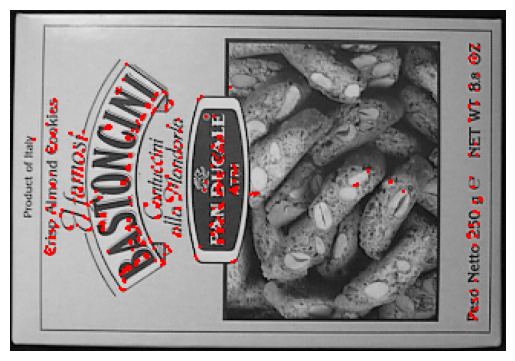

<Figure size 640x480 with 0 Axes>

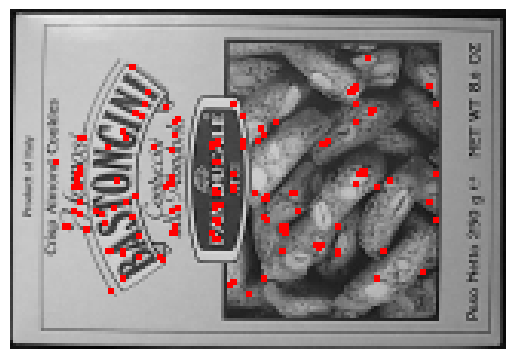

<Figure size 640x480 with 0 Axes>

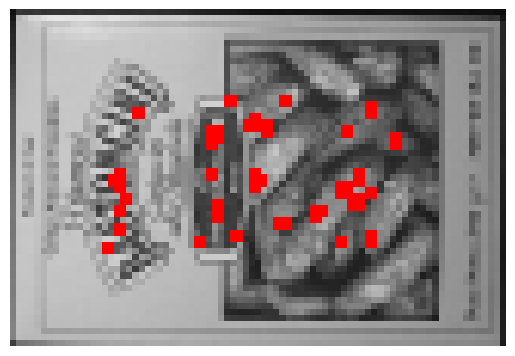

<Figure size 640x480 with 0 Axes>

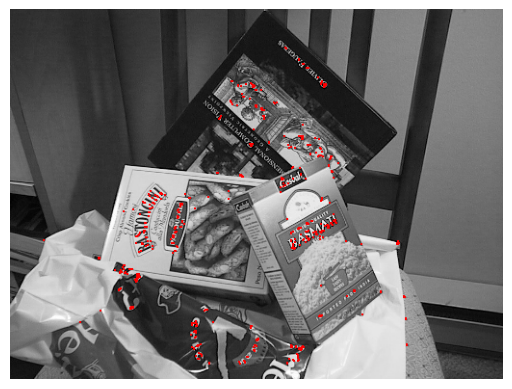

In [24]:
show_image(get_image_with_points(box, points_box))
show_image(get_image_with_points(box_x2, points_box_x2))
show_image(get_image_with_points(box_x4, points_box_x4))
show_image(get_image_with_points(test_image, points_test))

In [25]:
def get_moment(image, p, q, x, y, r):
    h, w = image.shape

    ci = h // 2
    cj = w // 2

    m = 0
    for i in range(max(0, x - r), min(h, x + r + 1)):
        for j in range(max(0, y - r), min(w, y + r + 1)):
            m += (i - ci) ** p * (j - cj) ** q * image[i, j]
    return m

In [26]:
def get_angles(image, points, r):
    angles = []
    for x, y in points:
        m01 = get_moment(image, 0, 1, x, y, r)
        m10 = get_moment(image, 1, 0, x, y, r)
        a = math.atan2(m01, m10) % (2 * np.pi)
        angles.append(a)

    return angles

In [27]:
angles_box = get_angles(box, points_box, 31)
angles_box_x2 = get_angles(box_x2, points_box_x2, 31)
angles_box_x4 = get_angles(box_x4, points_box_x4, 31)
angles_test = get_angles(test_image, points_test, 31)

In [29]:
def filter_gauss(K_size, sigma, im):
    H, W = im.shape

    pad = K_size // 2
    out = np.zeros((H + pad * 2, W + pad * 2), np.float64)
    out[pad : pad + H, pad : pad + W] = im.copy().astype(np.float64)

    K = np.zeros((K_size, K_size), np.float64)
    for x in range(-pad, -pad + K_size):
        for y in range(-pad, -pad + K_size):
            K[x + pad, y + pad] = np.exp(-(x * x + y * y) / (2 * (sigma * sigma)))
    K /= 2 * np.pi * sigma * sigma
    K /= K.sum()

    tmp = out.copy()

    for y in range(H):
        for x in range(W):
            out[pad + y, pad + x] = np.sum(K * tmp[y : y + K_size, x : x + K_size])
    out = np.clip(out, 0, 255).astype(int)
    return out[pad : pad + H, pad : pad + W]

In [30]:
blurred_box = filter_gauss(3, 100, box)
blurred_box_x2 = filter_gauss(3, 100, box_x2)
blurred_box_x4 = filter_gauss(3, 100, box_x4)
blurred_test = filter_gauss(3, 100, test_image)

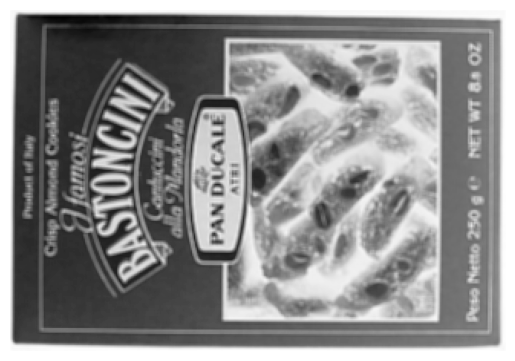

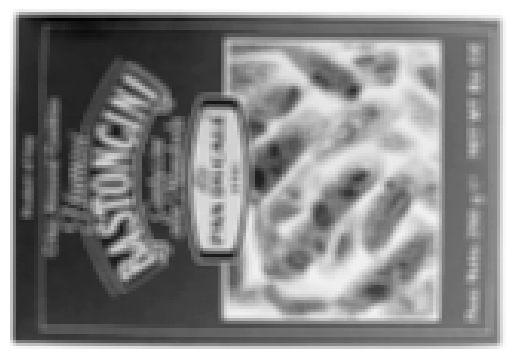

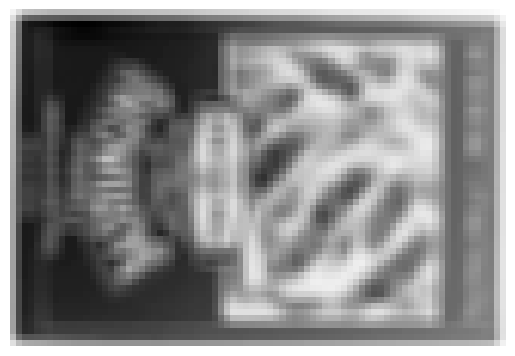

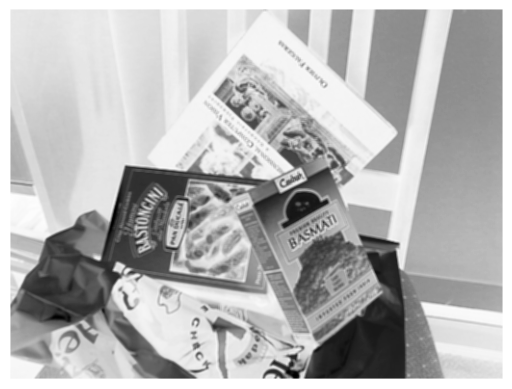

In [31]:
show_image(blurred_box)
show_image(blurred_box_x2)
show_image(blurred_box_x4)
show_image(blurred_test)

In [32]:
theta = np.linspace(0, 2 * np.pi, 30, endpoint=False)

[0.         0.20943951 0.41887902 0.62831853 0.83775804 1.04719755
 1.25663706 1.46607657 1.67551608 1.88495559 2.0943951  2.30383461
 2.51327412 2.72271363 2.93215314 3.14159265 3.35103216 3.56047167
 3.76991118 3.97935069 4.1887902  4.39822972 4.60766923 4.81710874
 5.02654825 5.23598776 5.44542727 5.65486678 5.86430629 6.0737458 ]


In [33]:
Rt = [np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]]) for t in theta]

In [34]:
S = (np.pi / 5) * np.random.randn(256, 2, 2)
S /= np.max(S)
S *= 31 // 2 - 2

In [36]:
St = []
for rt in Rt:
    st = []
    for i in range(S.shape[0]):
        st.append(np.array([rt.dot(S[i, 0]), rt.dot(S[i, 1])], dtype=int))
    St.append(st)

In [37]:
def get_descriptor(image, points, angles, n=256):
    def tau(p, x, y):
        return p[x[0], x[1]] < p[y[0], y[1]]

    descriptor = []
    for j in range(len(points)):
        c = points[j]

        t = len(theta) - 1
        for i in range(len(theta)):
            if angles[j] < theta[i]:
                t = i - 1
                break
        s = [[St[t][i][0] + c, St[t][i][1] + c] for i in range(n)]
        f = [tau(image, s[i][0], s[i][1]) for i in range(n - 1, -1, -1)]
        descriptor.append(np.array(f, dtype=int))

    return descriptor

In [38]:
desc_box = get_descriptor(blurred_box, points_box, angles_box)

In [39]:
desc_box_x2 = get_descriptor(blurred_box_x2, points_box_x2, angles_box_x2)
desc_box_x4 = get_descriptor(blurred_box_x4, points_box_x4, angles_box_x4)

In [40]:
desc_test = get_descriptor(blurred_test, points_test, angles_test)

## Начало 6-ой лабы

In [41]:
def descriptor_comparison_matrix(d1, d2):
    h = len(d1)
    w = len(d2)
    h_dist = np.zeros((h, w), dtype=int)

    for i in range(h):
        for j in range(w):
            v1 = d1[i]
            v2 = d2[j]
            d = sum(np.absolute(v1 - v2))
            h_dist[i, j] = d

    return h_dist

In [42]:
h_dist_box = descriptor_comparison_matrix(desc_box, desc_test)
print(h_dist_box)

[[128 137 118 ... 129 109 111]
 [146 133 116 ... 115 125 121]
 [138 165 114 ...  99 121  83]
 ...
 [ 91 118 135 ... 156 134 136]
 [143 148  87 ... 112 104 136]
 [108 107 146 ... 155 123 143]]


In [43]:
h_dist_box_x2 = descriptor_comparison_matrix(desc_box_x2, desc_test)
print(h_dist_box_x2)

[[136 143 124 ... 123 131  93]
 [111 106 133 ... 170 114 152]
 [165 146 123 ... 116 100 110]
 ...
 [116 117 166 ... 143 107 127]
 [131 124 167 ... 118 118 100]
 [121 134 111 ... 152 120 138]]


In [44]:
h_dist_box_x4 = descriptor_comparison_matrix(desc_box_x4, desc_test)
print(h_dist_box_x4)

[[131 118 157 ... 140 106 116]
 [131 122 167 ... 110 134 100]
 [143 134 133 ... 142 102  86]
 ...
 [158 135 134 ... 135 117 145]
 [120 127 140 ... 189 113 153]
 [131 150 145 ... 122 138 118]]


In [45]:
def Lowe_test(points1, points2, h_dist):
    R_Lowe = 0.8
    h, w = h_dist.shape

    result = []

    for i in range(h):
        sorted_dist = sorted(h_dist[i])
        for t in range(len(sorted_dist) - 1):
            dist1, dist2 = sorted_dist[t : t + 2]
            R = dist1 / dist2
            if R < R_Lowe:
                j = np.argwhere(h_dist[i] == dist1)[0][0]
                result.append([points1[i], points2[j]])
                break
    return result

In [46]:
lowe_box = Lowe_test(points_box, points_test, h_dist_box)
lowe_box_reversed = Lowe_test(points_test, points_box, h_dist_box.T)
print(len(lowe_box), len(lowe_box_reversed))
print(lowe_box)

4 12
[[(90, 132), (312, 205)], [(148, 299), (175, 336)], [(112, 249), (351, 305)], [(120, 147), (312, 205)]]


In [47]:
lowe_box_x2 = Lowe_test(points_box_x2, points_test, h_dist_box_x2)
lowe_box_x2_reversed = Lowe_test(points_test, points_box_x2, h_dist_box_x2.T)
print(len(lowe_box_x2), len(lowe_box_x2_reversed))
print(lowe_box_x2)

10 36
[[(79, 33), (243, 131)], [(79, 32), (243, 131)], [(75, 68), (243, 168)], [(81, 42), (246, 141)], [(80, 37), (244, 137)], [(79, 37), (243, 137)], [(81, 49), (246, 148)], [(64, 69), (231, 173)], [(59, 73), (226, 178)], [(31, 139), (237, 325)]]


In [48]:
lowe_box_x4 = Lowe_test(points_box_x4, points_test, h_dist_box_x4)
lowe_box_x4_reversed = Lowe_test(points_test, points_box_x4, h_dist_box_x4.T)
print(len(lowe_box_x4), len(lowe_box_x4_reversed))
print(lowe_box_x4)

1 18
[[(28, 41), (349, 292)]]


In [49]:
def cross_check(lowe_forward, lowe_reversed):
    points1 = []
    points2 = []
    for p1, p2 in lowe_forward:
        for pr1, pr2 in lowe_reversed:
            if p1 == pr2 and p2 == pr1:
                points1.append(p1)
                points2.append(p2)
    return points1, points2

In [50]:
cc_box = cross_check(lowe_box, lowe_box_reversed)
print(len(cc_box[0]), cc_box)

0 ([], [])


In [51]:
cc_box_x2 = cross_check(lowe_box_x2, lowe_box_x2_reversed)
print(len(cc_box_x2[0]), cc_box_x2)

7 ([(79, 32), (81, 42), (80, 37), (79, 37), (81, 49), (64, 69), (59, 73)], [(243, 131), (246, 141), (244, 137), (243, 137), (246, 148), (231, 173), (226, 178)])


In [52]:
cc_box_x4 = cross_check(lowe_box_x4, lowe_box_x4_reversed)
print(len(cc_box_x4[0]), cc_box_x4)

1 ([(28, 41)], [(349, 292)])


In [53]:
def bresenham(x0, y0, x1, y1, size):
    steps_num = int(np.max([np.abs(x0 - x1), np.abs(y0 - y1)]))
    sp = np.linspace(0, 1, steps_num + 1)

    x_coords = np.int32(np.round(x0 * sp + x1 * (1 - sp)))
    y_coords = np.int32(np.round(y0 * sp + y1 * (1 - sp)))

    x_ind = (x_coords > 0) & (x_coords < size)
    y_ind = (y_coords > 0) & (y_coords < size)
    ind = x_ind & y_ind

    x_coords = x_coords[ind]
    y_coords = y_coords[ind]

    return [a for a in zip(x_coords, y_coords)]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

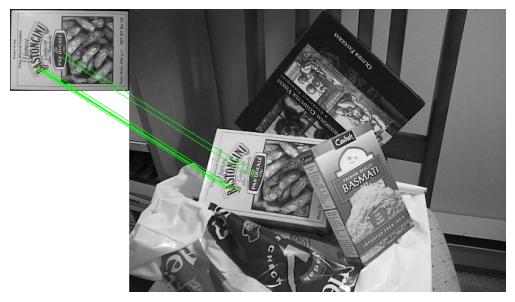

In [54]:
points1, points2 = cc_box_x2

detection = get_image_with_points(box_x2, points1)
picture = get_image_with_points(test_image, points2)

color = 0, 255, 0

w = detection.shape[1] + picture.shape[1]
h = max(detection.shape[0], picture.shape[0])

result_image = np.ones((h, w, 3), dtype=int) * 255
result_image[: detection.shape[0], : detection.shape[1]] = detection
result_image[: picture.shape[0], detection.shape[1] :] = picture


for i in range(len(points1)):
    x, y = points1[i]
    x2, y2 = points2[i]
    y2 += detection.shape[1]

    line = bresenham(x, y, x2, y2, h)
    for u, v in line:
        result_image[u, v] = color

show_image(result_image)

## Оценка параметров

In [55]:
def get_affine_parameters(object_coords, in_place_coords):
    x1, y1 = object_coords[0]
    x2, y2 = object_coords[1]
    x3, y3 = object_coords[2]

    u1, v1 = in_place_coords[0]
    u2, v2 = in_place_coords[1]
    u3, v3 = in_place_coords[2]

    m1 = ((u1 - u3) * (y1 - y2) - (u1 - u2) * (y1 - y3)) / ((x1 - x3) * (y1 - y2) - (x1 - x2) * (y1 - y3))
    m2 = ((u1 - u2) - m1 * (x1 - x2)) / (y1 - y2)
    tx = u1 - m1 * x1 - m2 * y1

    m3 = ((v1 - v3) * (y1 - y2) - (v1 - v2) * (y1 - y3)) / ((x1 - x3) * (y1 - y2) - (x1 - x2) * (y1 - y3))
    m4 = ((v1 - v2) - m3 * (x1 - x2)) / (y1 - y2)
    ty = v1 - m3 * x1 - m4 * y1

    return np.array([[m1, m2], [m3, m4]]), np.array([tx, ty]).reshape((2, 1))

In [56]:
def transform_points(points, M, T):
    return tuple(np.array(M @ np.array(p).reshape((2, 1)) + T, dtype=int) for p in points)

In [57]:
def lsm(points):
    if len(points) < 3:
        raise ValueError

    A = []
    B = []

    for (x1, y1), (x2, y2) in points:
        A.append([x1, y1, 0, 0, 1, 0])
        A.append([0, 0, x1, y1, 0, 1])
        B.append(x2)
        B.append(y2)

    A = np.array(A, dtype=float)
    B = np.array(B, dtype=float)

    x = np.linalg.inv(A.T @ A) @ A.T @ B

    return x[0:4].reshape((2, 2)), x[4:].reshape((2, 1))

In [58]:
def RANSAC(points, iter_count, diff):
    m = 3
    if len(points[0]) < m or len(points[1]) < m:
        raise ValueError

    points1, points2 = points

    max_inliers = 0
    max_points = len(points1)
    best_points = []
    for _ in range(iter_count):
        rand_indexes = list(range(max_points))
        random.shuffle(rand_indexes)
        rand_indexes = rand_indexes[:m]
        M, T = get_affine_parameters(
            tuple(points1[ind] for ind in rand_indexes), tuple(points2[ind] for ind in rand_indexes)
        )
        transformed_points = transform_points(points1, M, T)

        inlier_points = []
        for j in range(max_points):
            xt, yt = transformed_points[j]
            x2, y2 = points2[j]
            if abs(xt - x2) < diff and abs(yt - y2) < diff:
                inlier_points.append((points1[j][:], points2[j][:]))

        if len(inlier_points) == max_points:
            best_points = inlier_points
            break

        if len(inlier_points) > max_inliers:
            max_inliers = len(inlier_points)
            best_points = inlier_points

    return lsm(best_points)

In [73]:
M, T = RANSAC(cc_box_x2, 5, 2)

In [60]:
def get_detected_object_image(detection, picture, M, T):
    h_d, w_d = detection.shape
    h_p, w_p = picture.shape

    result_image = np.zeros((h_p, w_p, 3), dtype=int)
    for i in range(h_p):
        for j in range(w_p):
            result_image[i, j] += picture[i, j]

    color = [255, 255, 0]
    object_points_in_picture = transform_points(tuple((i, j) for i in range(h_d) for j in range(w_d)), M, T)

    for x, y in object_points_in_picture:
        result_image[x, y] = color

    return result_image

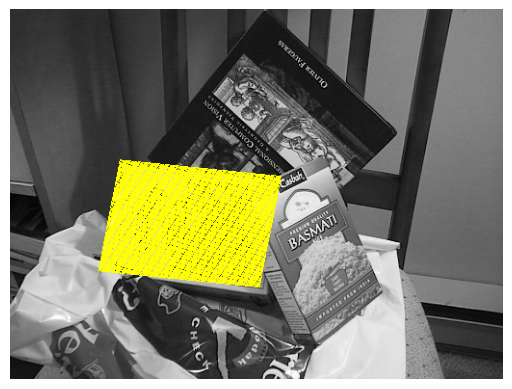

In [74]:
object_in_picture = get_detected_object_image(box_x2, test_image, M, T)
show_image(object_in_picture)